# Lecture 2 — Probability & Statistics I

[Open this notebook in Google Colab](https://colab.research.google.com/github/daanmeerburg/Statistics_meerburg_2026/blob/main/Lectures/Lecture_02_PDM.ipynb)

**Lecturer:** P. D. Meerburg 

*Heavily based on materials by Davide Gerosa (astroML, 2022) and collaborators. See [here](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/README.md) for credits.*


##### Reading:

- [Ivezic textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 3. 
- [David Hogg: "Data analysis recipes: Probability calculus for inference"](https://arxiv.org/abs/1205.4446)





---

>## Preliminaries and notation <a class="anchor" id="one"></a>

* **"Statistics"** = extracting knowledge from data.
* **"Knowledge"** = summary (physical or phenomenological) of data behavior.
* **"Data"** = result of measurements.

In the textbook, $x$ is a scalar quantity that is measured $N$ times to form a dataset.

* $x_i$ is a single measurement with $i=1,...,N$.
* $\{x_i\}$ refers to the set of all N measurements comprising the dataset. 

Our data can be real numbers, discrete labels (strings or numbers), or even "missing values" (we sometimes pad our datasets with NaNs in this case). 

**Goal of data mining & statistical inference:**
> We are generally trying to *estimate* $h(x)$, the *true* generating distribution from which $\{x_i\}$ are drawn. 

* $h(x)$ is the **probability density (distribution) function** or the **"pdf"** and $h(x)dx$ is the probability of a value lying between $x$ and $x+dx$. This distribution can have several levels-- the population distribution of events (e.g. source redshifts), and a measurement uncertainty distribution that blurs our measured data away from true values.

* The "left to right" integral of $h(x)$ is the **cumulative distribution function** (**"cdf"**), $H(x) = \int_{-\infty}^x h(x')dx'$. The inverse function of the cdf is the **quantile function**, e.g. what $x$ value has 90% of the distribution below it?

* While $h(x)$ is the "true" pdf (or **population** pdf), what we *measure* from the data is the **empirical** pdf, which is denoted $f(x)$.  So, $f(x)$ is a *model* of $h(x)$.  In principle, with infinite data $f(x) \rightarrow h(x)$, but in reality the blurring effect of measurement errors keep this from being strictly true. Likewise, the empirical cdf is denoted $F(x)$.

* If we are attempting to guess a physical *model* for $h(x)$, then the process is ***parametric***.  With a model solution we can generate new data that should mimic what we measure.  If we are not attempting to guess a model, then the process is ***non-parametric***, i.e. we are just trying to describe the data behavior in a compact practical way.

**Picturing (i.e. understanding!) a pdf is not a trivial task!**

Let's see an example. This cell will start with a generating distribution $h(x)$, draw a number of random samples as data $\{x_i\}$, and then fit these data with a parametric and non-parametric model $f(x)$.

Let us first set up the code, load some libs and make sure we make nice plots. The original lectures by Davide had some errors when running the script due boolian defined in numpy. This is fixed in this version.  

In [1]:
# --- Universal, LaTeX-free plotting setup (safe on any system) ---
import numpy as np
import matplotlib.pyplot as plt

# Compatibility patch for astroML / NumPy >= 1.24
if not hasattr(np, "bool"):
    np.bool = bool

# Consistent, publication-quality plot style
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,   # explicitly disable LaTeX rendering
    "figure.figsize": (6, 4),
    "figure.dpi": 100
})

%config InlineBackend.figure_format = 'retina'

In [2]:
# Install required libraries only when running on Google Colab
import sys

def install(pkg):
    !pip install {pkg}

if 'google.colab' in sys.modules:
    print("Running in Google Colab — installing required packages...")
    for pkg in ["astroML", "astropy", "corner", "emcee"]:
        install(pkg)
else:
    print("Running locally — assuming required packages are installed.")


Running locally — assuming required packages are installed.


In [3]:
# Based on Ivezic v2, Figure 6.8; edited by G. T. Richards, S. R. Taylor, and D. Gerosa

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general


from scipy import stats

from sklearn.neighbors import KernelDensity

from astropy.visualization import hist
from sklearn.mixture import GaussianMixture


Next, let us generate some data. We will use a mix of Cauchy distributions that you can call from the stats package. It is not the point, we just want to generate some random data that could be data from some type of measurement (and that is not a simple Gaussian). 

In [4]:
# Generate our data: a mix of several Cauchy distributions (see Chapter 3.3.5)
# In reality nature generates data for you

random_state = np.random.RandomState(seed=0)
N = 2000 # number of data points--> you can make this larger if you want a smoother result.
#define an array of (mu, gamma, f) tuples
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
#generate the true distribution function using the array above
hx = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
#generate random samples from the true distribution function
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N), random_state=random_state)
                    for (mu, gamma, f) in mu_gamma_f])
# Shuffle and trim the data to a reasonable range
random_state.shuffle(x)
x = x[x > -10]
x = x[x < 30]

Next, let us print this array. Not very insightful, but we can plot it later. 

In [5]:
# These are the numbers you have. 
#Say these are stellar flux measurements, or a time series from a gravitational-wave detector

print(x.tolist())

[8.952596638950636, 6.942533358935216, 11.857502968790328, 7.9673676256550765, 8.339793768997135, 9.104030518710326, 9.03488289822448, 9.00066149734176, 12.068202801788292, 12.43803660691054, 9.171912910373512, 9.32457387753589, 12.793456190615046, 7.649754269389245, 6.957712694613811, 5.212342443874667, -0.5858969407576256, 10.819198381549345, 6.001707605068017, 12.208739158947212, 15.623442221914669, 9.12180574588649, 12.097206156705552, 11.752914357372386, 7.624716805403909, 9.127190737797093, 4.72461107622859, 7.039304136974619, 5.608240319346324, 6.5331353251927435, 6.595590247300794, 14.350048371783956, 6.734318572151493, 7.01540998481395, 9.000751889624222, 5.6912891917117365, 12.940548902826198, 8.951356409071611, 4.261082360738824, 7.074183889581066, 7.773505002260369, 7.599377398071212, 7.578337462319974, 6.661074122722392, 7.032526365073723, 3.70137114216083, 14.14247265328622, 15.2022714128919, 4.756113643850473, 5.379878776596009, 6.710777342736698, 7.121288020008638, 8.25

Now let us plot the results. 

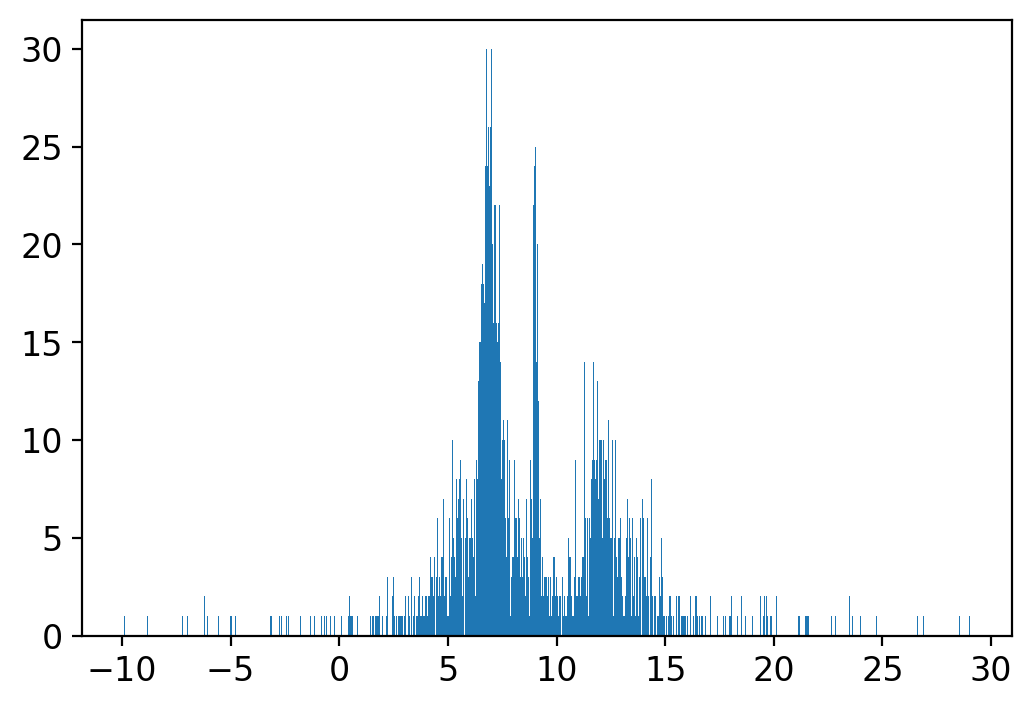

In [6]:
#Let's do the easiest thing ever.
plt.hist(x,bins=1000); #you can adjust the number of bins if you want.

Of course, this distribution is just a random distribution, but we can try and find $h(x)$ by fitting the data to some distribution. 

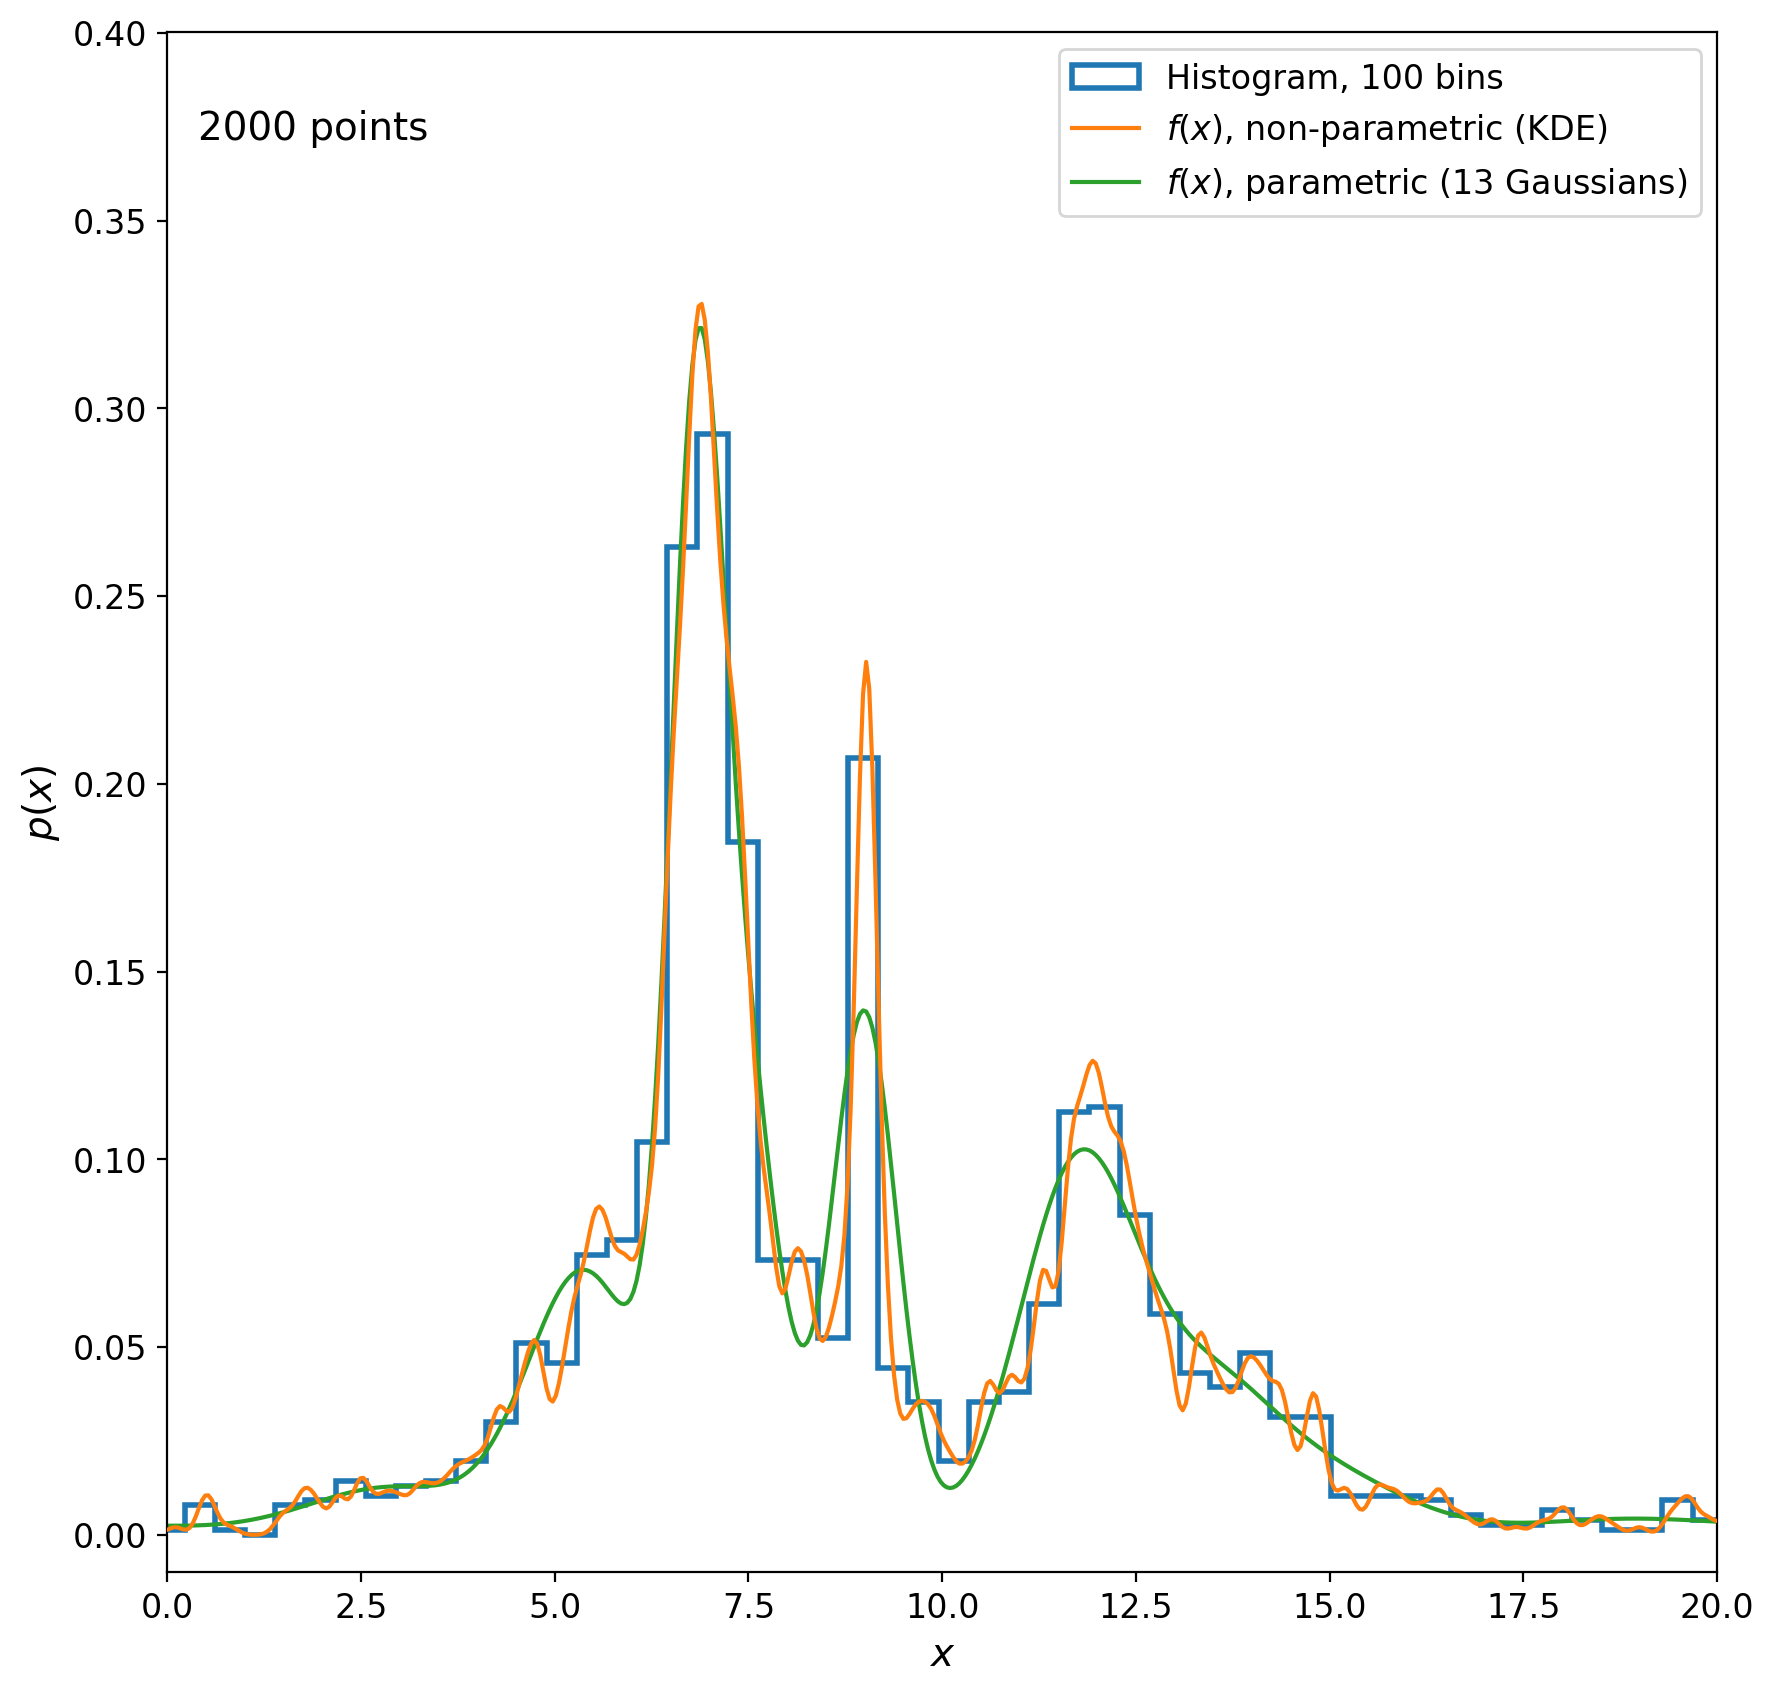

In [7]:

# plot the results
fig,ax = plt.subplots(figsize=(10, 10))
xgrid = np.linspace(-10, 30, 1000)

# True distribution: you typically don't have it! Only have the samples!
if False:
    ax.plot(xgrid, hx(xgrid), ':', color='black', zorder=3,
            label="$h(x)$, Generating Distribution")

# A simple histogram
# But try changing the number of bins!
if True:
    ax.hist(x,density=True,color='C0',bins=100,histtype='step',lw=2, label='Histogram, 100 bins')

# Something more sophisticated: Kernel Density Estimation, see section 6.1.1
# But try changing the bandwith! 
if True:
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(x[:, None])
    dens_kde = np.exp(kde.score_samples(xgrid[:, None]))
    ax.plot(xgrid, dens_kde, '-', color='C1', zorder=3,
            label="$f(x)$, non-parametric (KDE)")

# Use Gaussian Mixtures with a pre-defined number of clusters (13), see section 6.3.1
if True:
    gmm = GaussianMixture(n_components=13).fit(x.reshape(-1, 1))
    logprob = gmm.score_samples(xgrid.reshape(-1, 1))
    fx = lambda j : np.exp(gmm.score_samples(j.reshape(-1, 1)))
    ax.plot(xgrid, fx(np.array(xgrid)), '-', color='C2',
            label="$f(x)$, parametric (13 Gaussians)")

# Plot cosmetics
ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)

ax.set_ylabel('$p(x)$',fontsize=14)
ax.legend(loc='upper right')

ax.set_xlabel('$x$',fontsize=14)
ax.set_xlim(0, 20)
ax.set_ylim(-0.01, 0.4001)

plt.show()


Consider the probability of a single value "9", as estimated from the true distribution, the parametric KDE or the GaussianMixture. 

In [8]:
# --- Detailed demonstration: see preceding markdown ---
# For instance in a single point:
print(hx(9))             # h(x), the true distribution

print(fx(np.array([9]))) # f(x) for a parametric model
print(np.exp(kde.score_samples(np.atleast_2d(9)))) # f(x) for non-parametric model

0.34357186498273545
[0.13976884]
[0.23034853]


>**So the results widely differ!**

We could also check if these probabilities are properly normalized. 

For example, let us consider the KDE. 

In [10]:
# Assuming 'xgrid' is the range of values and 'dens_kde' is the KDE density values
integral = np.trapezoid(dens_kde, xgrid)

# Check if the integral is approximately equal to 1
is_normalized = np.isclose(integral, 1.0)

print(f"Integral of the KDE: {integral}")

Integral of the KDE: 0.9999290990364952


So not exactly 1, but pretty close. What about the GaussianMixture? 

In [11]:
# Assuming 'xgrid' is the range of values and 'dens_kde' is the KDE density values
integral = np.trapezoid(fx(np.array(xgrid)), xgrid)

# Check if the integral is approximately equal to 1
is_normalized = np.isclose(integral, 1.0)

print(f"Integral of the KDE: {integral}")

Integral of the KDE: 0.9998662659037179


____

>## A note on uncertainties and errors

* Technically, errors are systematic biases that we can not mitigate through collecting lots and lots of data. 
* Statistical uncertainties are the result of random measurement uncertainty. 
* But "error" will be used for both, and denoted as either statistical errors (error bars) or systematic errors (biases).


* Statistical error distributions (error bars) that vary from data point to data point are called **heteroscedastic errors**. If they are the same for all points then they are **homoscedastic errors**.

___
>##  We could summarize the goal of this course as an attempt to 

1) estimate $f(x)$ from some real (possibly multi-dimensional) data set, 

2) find a way to describe $f(x)$ and its uncertainty, 

3) compare it to models of $h(x)$, and then 

4) use the knowledge that we have gained to interpret/predict new measurements.

___
>## Probability <a class="anchor" id="two"></a>

> $p(A)$ = the probability of $A$ (or the probability density at $A$) 

e.g. the probability that an observed object is a galaxy. This does not mean that the object is in some sort of Schrödinger's cat quantum uncertainty...*the probability reflects our current state of knowledge of the object, and our belief that it is a galaxy*. 

**Probability axioms (Kolmogorov)**

1. $p(A)\geq0 \quad\forall\, A$ ($\forall$ means for all)
2. $p(\Omega) = 1$, where $\Omega$ is the set of all outcomes, i.e. the sum/integral of all possible outcomes is unity
3. $p(\cup_{i=1}^\infty A_i) = \sum_{i=1}^\infty p(A_i)$ if all events are independent

$A \cup B$ is the *union* of sets $A$ and $B$. **Read as A OR B.**

$A \cap B$ is the *intersection* of sets $A$ and $B$. **Read as A AND B.** Different notations $p(A \cap B) = p(AB) = p(A,B) = p(A\,\mathrm{and}\,B)$. We will use the comma notation throughout. 

If we have two events, $A$ and $B$, the possible combinations are illustrated by the following figure:


![Figure 3.1](http://www.astroml.org/_images/fig_prob_sum_1.png)

* The probability that ***either*** $A$ ***or*** $B$ will happen (which could include both) is the *union*, given by
$$p(A \cup B) = p(A) + p(B) - p(A \cap B)$$
The figure makes it clear why the last term is necessary.  Since $A$ and $B$ overlap, we are double-counting the region where *both* $A$ and $B$ happen, so we have to subtract this out.  


* The probability that ***both*** $A$ ***and*** $B$ will happen, $p(A \cap B)$, is 
$$p(A \cap B) = p(A|B)p(B) = p(B|A)p(A)$$
where $p(A|B)$ is the probability of A *given that* B is true and is called the **conditional probability**.  So the $|$ is short for "given".


* The **law of total probability** says that (for independent $B_i$)
$$p(A) = \sum_ip(A|B_i)p(B_i)$$

It is important to realize that the following is *always* true:

$$p(A,B) = p(A|B)p(B) = p(B|A)p(A)$$

However, if $A$ and $B$ are independent, then $p(A|B)=p(A)$ and $p(B|A)=p(B)$ and

$$p(A,B) = p(A)p(B)$$

>**EXAMPLE 1** (classic marbles in bag scenario)

If you have a bag with 5 marbles (3 yellow and 2 blue) and you want to know the probability of picking 2 yellow marbles in a row, that would be

$$p(Y_1,Y_2) = p(Y_1)p(Y_2|Y_1).$$

$p(Y_1) = \frac{3}{5}$ since you have an equally likely chance of drawing any of the 5 marbles.

If you did not put the first marble back in the back after drawing it (sampling *without* "replacement"), then the probability

$p(Y_2|Y_1) = \frac{2}{4}$, so that

$$p(Y_1,Y_2) = \frac{3}{5}\frac{2}{4} = \frac{3}{10}.$$

But if you put the first marble back, then

$p(Y_2|Y_1) = \frac{3}{5} = p(Y_2)$, so that 

$$p(Y_1,Y_2) = \frac{3}{5}\frac{3}{5} = \frac{9}{25}.$$

In the first case $A$ and $B$ (or rather $Y_1$ and $Y_2$) are *not* independent, whereas in the second case they are.

**Need more help with this?**  Try watching some Khan Academy videos and working through the exercises:
* [https://www.khanacademy.org/math/probability/probability-geometry](https://www.khanacademy.org/math/probability/probability-geometry)
* [https://www.khanacademy.org/math/precalculus/prob-comb](https://www.khanacademy.org/math/precalculus/prob-comb)

---

>## Bayes' Theorem <a class="anchor" id="three"></a>

In the following figure, we have a 2-D distribution in $x-y$ parameter space.  Here $x$ and $y$ are ***not*** independent as, once you pick a $y$, your values of $x$ are constrained.

![http://www.astroml.org/_images/fig_conditional_probability_1.png](http://www.astroml.org/_images/fig_conditional_probability_1.png)

We have that 
$$p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$

We can define the ***marginal probability*** as
$$p(x) = \int p(x,y)dy,$$

where marginal means projecting on to one axis (integrating over the unwanted variable). The **marginal** distributions are shown on the left and bottom sides of the left panel.  As the equation above says, this is just the integral along the $x$ direction for a given $y$ (left side panel) or the integral along the $y$ direction for a given $x$ (bottom panel).  

The three panels on the right show the ***conditional probability*** (of $x$) for three $y$ values: $$p(x|y=y_0)$$  These are just normalized "slices" through the 2-D distribution.

The marginal probability of $x$ can be re-written as

$$p(x) = \int p(x|y)p(y) dy$$

But since $p(x|y)p(y) = p(y|x)p(x)$, we can write

> $$p(y|x) = \frac{p(x|y)p(y)}{p(x)} = \frac{p(x|y)p(y)}{\int p(x|y)p(y) dy}$$

which in words says that

> the (conditional) probability of $y$ given $x$ is just the (conditional) probability of $x$ given $y$ times the (marginal) probability of $y$ divided by the (marginal) probability of $x$, where the latter is just the integral of the numerator.

This is **Bayes' Theorem**, which itself is not at all controversial, though its application can be as we'll discuss later.

>**EXAMPLE 2:** 
Bayes' Theorem Example: Lego's <a class="anchor" id="four"></a>

An example with Lego's (it's awesome, let's have a look!):
[https://www.countbayesie.com/blog/2015/2/18/bayes-theorem-with-lego](https://www.countbayesie.com/blog/2015/2/18/bayes-theorem-with-lego)

(This example comes from a very nice book: [Bayesian Statistics the Fun Way](https://www.amazon.com/Bayesian-Statistics-Fun-Will-Kurt/dp/1593279566/))

>**EXAMPLE 3:** 
Bayes' Theorem Example: Contingency Table and COVID Tests (please show your skeptical aunts and anies)

We can also use Bayes' rule to learn something about false positives and false negatives.

Let's look at COVID tests.  The test can be positive ($T=1$) or negative ($T=0$) and one can either have the disease ($D=1$) or not ($D=0$).  So, there are 4 possible combinations:
$$T=0; D=0 \;\;\;  {\rm true \; negative}$$
$$T=0; D=1 \;\;\; {\rm false \; negative}$$
$$T=1; D=0 \;\;\; {\rm false \; positive}$$
$$T=1; D=1 \;\;\; {\rm true \; positive}$$

All else being equal, you have a 50% chance of being misdiagnosed. Not good! But the probability of disease and the accuracy of the test presumably are not random.

If the rates of false positive and false negative are:
$$p(T=1|D=0) = \epsilon_{\rm FP}$$
$$p(T=0|D=1) = \epsilon_{\rm FN}$$

then the true positive and true negative rates are just:
$$p(T=0| D=0) = 1-\epsilon_{\rm FP}$$
$$p(T=1| D=1) = 1-\epsilon_{\rm FN}$$

Let's assume that $\epsilon_{\rm FP}=0.02$ and $\epsilon_{\rm FN}=0.001$. 

In graphical form this $p(T|D)$ matrix is:

![http://www.astroml.org/_images/fig_contingency_table_1.png](http://www.astroml.org/_images/fig_contingency_table_1.png)

If we have a **prior** regarding how likely the disease is, we can take this into account.

$$p(D=1)=\epsilon_D$$

and then $p(D=0)=1-\epsilon_D$. Say, $\epsilon_D$ = 0.01 (so 1%)

Now assume that a person tested positive. What is the probability that this person has the disease? Is it 98% 
because $\epsilon_{\rm FP}=0.02$?

We can't just read $p(D=1|T=1)$ off the table because the table entry is the conditional probability of the *test* given the *disease*, $p(T=1|D=1)$. What we want is the conditional probability of the *disease* given the *test*, that is, $p(D=1|T=1)$.

Bayes' Theorem then can be used to help us determine how likely it is that you have the disease if you tested positive:

$$p(D=1|T=1) = \frac{p(T=1|D=1)p(D=1)}{p(T=1)},$$

where $$p(T=1) = p(T=1|D=0)p(D=0) + p(T=1|D=1)p(D=1).$$

So
$$p(D=1|T=1) = \frac{(1 - \epsilon_{FN})\epsilon_D}{\epsilon_{FP}(1-\epsilon_D) + (1-\epsilon_{FN})\epsilon_D} \approx \frac{\epsilon_D}{\epsilon_{FP}+\epsilon_D}$$

where in the final approximation we assume that all $\epsilon$ values are small. That means that to get a reliable diagnosis, we need $\epsilon_{FP}$ to be quite small.  (Because you *want* the probability to be close to unity if you test positive, otherwise it is a *false* positive).

In our example, we have a disease rate of 1% ($\epsilon_D = 0.01$) and a false positive rate of 2% ($\epsilon_{\rm FP}=0.02$).  

So we have
$$p(D=1|T=1) = \frac{0.01}{0.02+0.01} = 0.333$$

So even though the test is quite reliable (2% false positive), the probabilty that the person actually has the desease is only 1 in 3! 

This is one of the main reasons why in modern medicine, doctors tend to be very reluctant to do exhaustive testing. Suppose you have a common desease, that has a reliable test. In that case we have $\epsilon_D \gg \epsilon_{FP}$, and hence:
$$p(D=1|T=1) \simeq 1 - \epsilon_{FP}/\epsilon_D \sim 1,$$
i.e., the results of the test will lead to strong belief that the person actually has the disease. 

Now consider the opposite. A very rare disease (and we have many of those) and a somewhat unreliable test. In that case we have $\epsilon_{FP} \gg \epsilon_{D}$ and 
$$ p(D=1|T=1) \simeq \epsilon_D/\epsilon_{FP} \ll 1,$$
i.e., we find many folks that test positive and actually do not have the disease. This is bad because it would lead to starting many treatments for illment that people dont have. 

For those of you in the Netherlands who listen to the radio, you might have heard about prescan. This is aimed at seniors who want to scan for illmens outside general care. But based on the above you see this is probably not wise as long as you have no immediate reasons to suspect you have an illment (you could fold in the likelihood of the illment, given the symptoms and this will affect the above result. It is just that testing blindly as a bad idea). 

____
>## Transformations of random variables

If $x$ is a random variable then $f(x)$ is also a random variable for any function $f$.

To transform probability distributions when taking functions of random variables, we can simply use conservation of dimensionless probability, i.e. 

$$\mathrm{Prob}(x, x+dx) = \mathrm{Prob}(y, y+dy)$$

$$p(x)dx = p(y)dy$$
where $y = f(x)$.

Thus, $$p(y) = \left|\frac{dx}{dy}\right| p(x)$$.

>**EXAMPLE 4:**

* Let $x$ be a random variable drawn from a uniform distribution between $0$ and $1$. So $p(x) = 1/(1-0) = 1$.  
* Let's transform to $y = e^x$.
* So $p(y) = \left|dy/dx\right|^{-1}p(x) = 1/y$.

![https://www.astroml.org/_images/fig_transform_distribution_1.png](https://www.astroml.org/_images/fig_transform_distribution_1.png)

>**EXAMPLE 5:** Bayes' Theorem Example: Monty Hall Problem (or "Deal Or No Deal")

A very famous stats mind trick... You might have seen this already.

The [Monty Hall Problem](https://en.wikipedia.org/wiki/Monty_Hall_problem) was originally posed (and solved) in a letter by Steve Selvin to the American Statistician in [1975](https://www.tandfonline.com/doi/abs/10.1080/00031305.1975.10479121). It became famous as a question from reader Craig F. Whitaker's letter quoted in Marilyn vos Savant's "Ask Marilyn" column in Parade magazine in 1990.


You are playing a TV game show and are shown 2 doors.  One has a car behind it, the other a goat.  What are your chances of picking the door with the car?

OK, now there are 3 doors: one with a car, two with goats.  The game show host asks you to pick a door, but not to open it yet.  Then the host opens one of the other two doors (that you did not pick) and that has a goat.  The host offers you the opportunity to switch doors.

- One player decides to switch
- Another player prefers to stay with the previous choice
 
![https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/180px-Monty_open_door.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/180px-Monty_open_door.svg.png)

- Now a third player comes in who has not seen what happened earlier. They pick a door.

*Which of the three players is most likely to win?*

You might know or remember the answer already... but don't think now! **Let's simulate it**. 


First, let us compute this using Bayesian statistics. 

___
>## Assignment


**Simulate the Monty Hall Problem. You are allowed to do it with a group.**
- Simulate three doors, one car, and two goats.
 - Simulate three players: the switcher, the conservative, and the newcomer. 
 - Record who wins.
 - Repeat it many times.
 - Which player do you want to be?
 
 - What would happen if you had 100 doors to choose from and the presenter opens 98 or them?